##  Congratulations, you are now hired as a sport analytic. Your job is to give prediciton for the next Mathball tournament of the Six finest mathematicians in the world, which is a competition between Laplace, Gauss, Newton, Euler, Leibniz, Von-Neumann.

## The mathball is just like football where a player a goal is legal only after scoring you answer correctly a math question. 

## Motivation:  
### We want to infer a latent parameter - that is the 'strength' of a mathematician based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team.


In [27]:
# imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pickle as pkl

## The input   looks like as follows: 

In [28]:
group = 19
df_all  = pkl.load(open('../data_mathball/mathball_data_group_' + str(group)+ '.pkl', 'rb'))
df_all.head()

,home_player,away_player,home_score,away_score,year
0,Gauss,Leibniz,30,10,1897
1,Newton,Gauss,17,19,1897
2,Newton,Laplace,0,20,1897
3,Leibniz,Laplace,11,52,1897
4,Gauss,Euler,20,22,1897


## We have home and away team, we have score and year. 

## What do we want to infer?

### We want to infer the latent parameters (every mathematian's strength) that are generating the data we observe (the scorelines).
### Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.

## What do we want?

### We want to quantify our uncertainty
### We want to also use this to generate a model
### We want the answers as distributions not point estimates

## Part 1

### We next do some exploratory data analysis. The idea is to get a general sense of what is going on.

### 1. Plot a bar chart of the goal difference (i.e., total scored minus total scored against) per mathematician. Who is the best mathematician and who is the worst according to this plot?

Based on the bar chart of goal differences per mathematician, it's clear that Laplace stands out as the best performer in the Mathball tournament. He has the highest positive goal difference by a significant margin and as seen in the plot also, Leibniz emerges as the worst performer according to this metric, Leibniz's bar extends far into the negative territory-

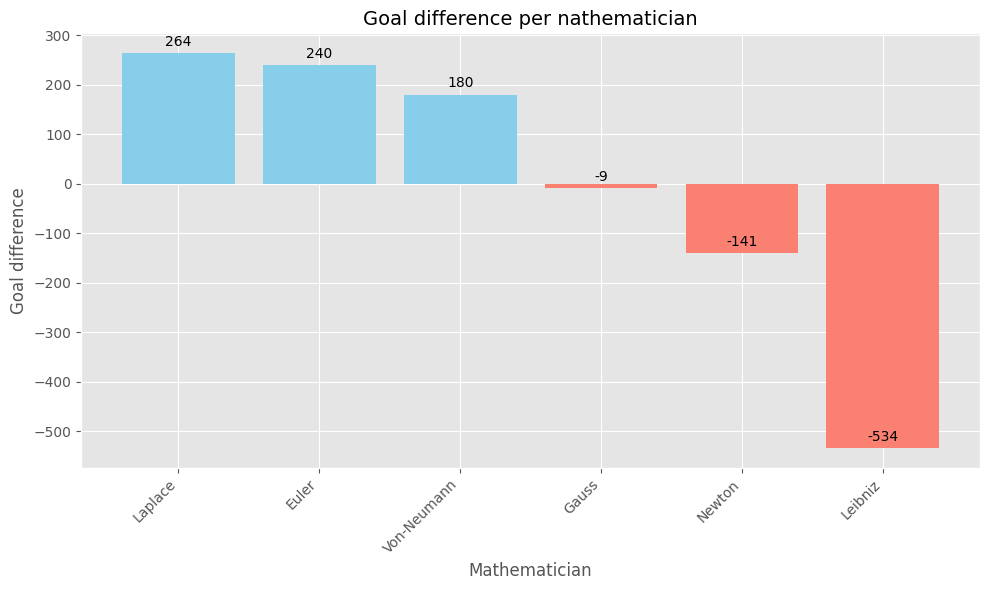

In [29]:
plt.style.use('ggplot') # Style to use in all the graphs from here

# Calculating goal difference for each mathematician
df_all['goal_difference_home'] = df_all['home_score'] - df_all['away_score']
df_all['goal_difference_away'] = df_all['away_score'] - df_all['home_score']

# Grouping by mathematician
goal_diff_home = df_all.groupby('home_player')['goal_difference_home'].sum()
goal_diff_away = df_all.groupby('away_player')['goal_difference_away'].sum()

# Sum of the goal differences
goal_diff = goal_diff_home.add(goal_diff_away, fill_value=0).sort_values(ascending=False)

# Creating the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(goal_diff.index, goal_diff.values, color=np.where(goal_diff.values > 0, 'skyblue', 'salmon')) # Color based on positive or negative values

# Adding value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Enhancing the plot
plt.xticks(rotation=45, ha="right")
plt.ylabel('Goal difference', fontsize=12)
plt.xlabel('Mathematician', fontsize=12)
plt.title('Goal difference per nathematician', fontsize=14)
plt.tight_layout()

plt.show()

### 2. Plot the same bar chart for each mathematician  as a function of time. Do you see a monote behvaoir which implies an improvement or the other way around for one of mathematician?

Analyzing the performance trends from 1897 to 1900, Newton's performance notably improves each year from a highly negative goal difference, turning positive by 1899 before a slight decline in 1900, while Euler's performance generally declines with a minor improvement in the last year, indicating no strict monotonic trend. Gauss's performance is marked by fluctuations, showing no clear trend, whereas Von-Neumann experiences an upturn for the first three years followed by a sharp decline in 1900. Laplace's performance dips between 1897 and 1898, then progressively improves until 1900. This analysis reveals that there isn't a consistent monotonic trend across the players, as all exhibit variances in their score trends over the years. 

The exception is Leibniz, who, despite showing a consistent, negative, monotonic trend, indicates a decrease in negative scores over time, highlighting some signs of poor game statistics.

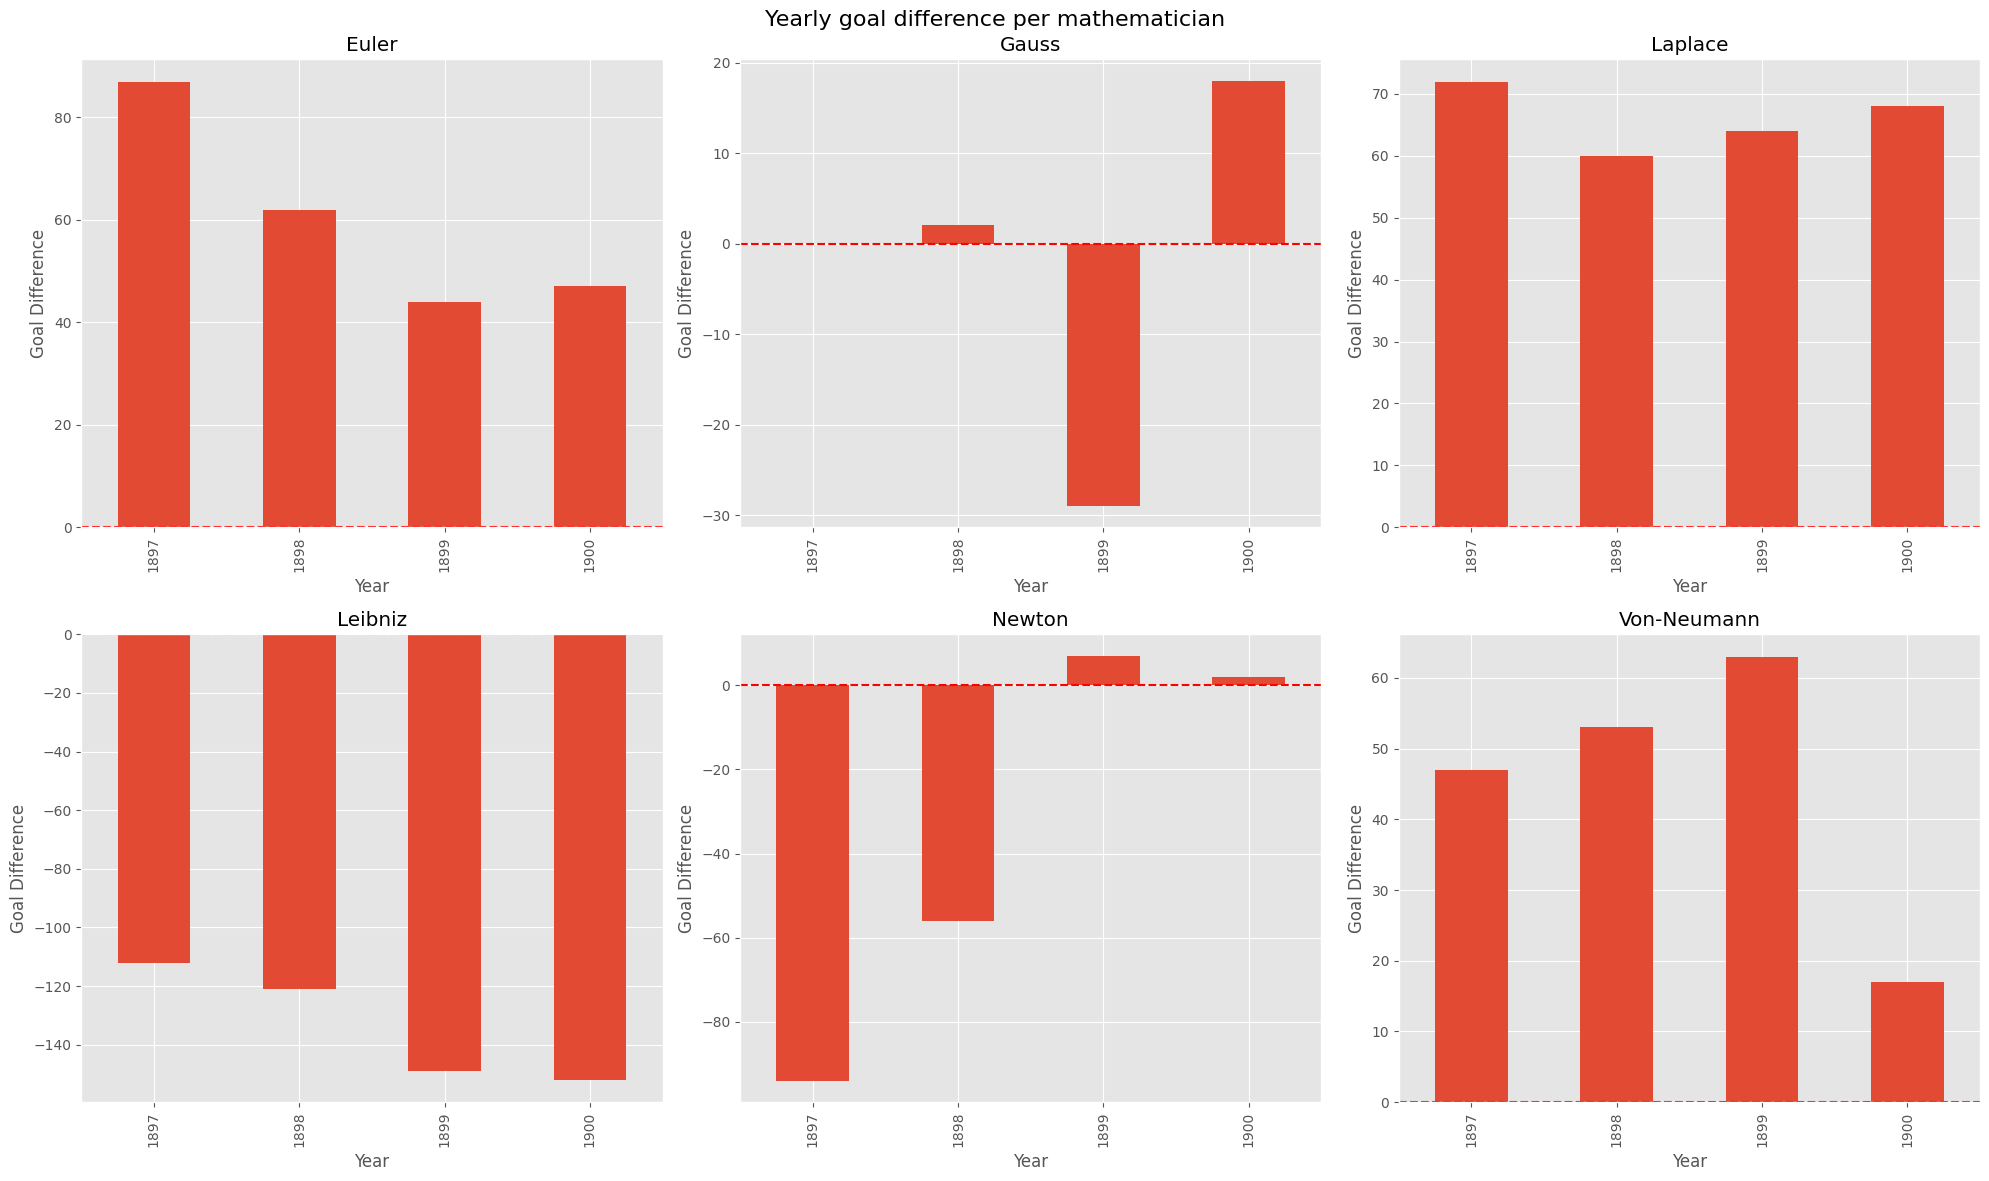

In [30]:
# Calculating yearly goal difference for each mathematician using groupby function
df_all['year'] = df_all['year'].astype(int)
yearly_goal_diff_home = df_all.groupby(['year', 'home_player'])['goal_difference_home'].sum().unstack().fillna(0) # Unstack is to maek the data more readable and make the graphs
yearly_goal_diff_away = df_all.groupby(['year', 'away_player'])['goal_difference_away'].sum().unstack().fillna(0) # Fillna in case there are years with no data

# Sum of the yearly goal differences
yearly_goal_diff = yearly_goal_diff_home.add(yearly_goal_diff_away, fill_value=0)

# Creating a figure with subplots for each mathematician
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Yearly goal difference per mathematician', fontsize=16)
axes = axes.flatten()

# Plotting bar chart for each mathematician
for i, mathematician in enumerate(yearly_goal_diff.columns):
    yearly_goal_diff[mathematician].plot(kind='bar', ax=axes[i], title=mathematician)
    axes[i].set_ylabel('Goal Difference')
    axes[i].set_xlabel('Year')
    
    # Adding a horizontal line at y=0 for reference of negativa and positive trends to answer the question
    axes[i].axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

### 3. Choose your favorite mathematician, compare the goal difference between home and away games. Is he better in home or away games? Plot a bar chart of the goal difference for both home and away games. 

Our favorite player is Laplace since he was the most consistent one with an upward trend in goal differnce by year. He scored better at home games than away games.

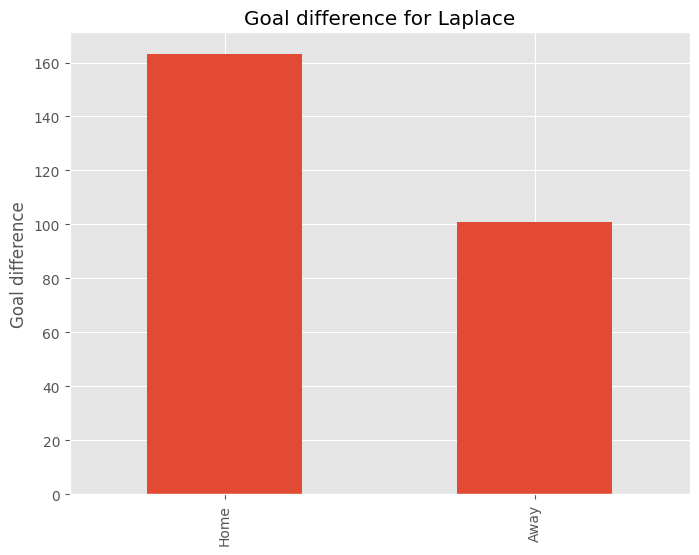

In [31]:
favorite_mathematician = 'Laplace'

# Calculating goal difference for home and away games for the specific player we decided
favorite_home_diff = df_all[df_all['home_player'] == favorite_mathematician]['goal_difference_home'].sum()
favorite_away_diff = df_all[df_all['away_player'] == favorite_mathematician]['goal_difference_away'].sum()

# Plotting the bar chart
data_favorite_platyer = pd.Series({'Home': favorite_home_diff, 'Away': favorite_away_diff})
data_favorite_platyer.plot(kind='bar', figsize=(8, 6), title=f'Goal difference for {favorite_mathematician}')
plt.ylabel('Goal difference')
plt.show()

### 4. Which mathematician has the best median away results? (that is, for each mathematician go over all of his away games, compute his scoring difference (how much he scored minues got scored against) and compute the median value).

In [32]:
# Calculate median goal difference for away games for each mathematician
median_away_diff = df_all.groupby('away_player')['goal_difference_away'].median()

# Find the mathematician with the best median away results
best_median_away = median_away_diff.idxmax()
best_median_value = median_away_diff.max()

print(f'The mathematician with the best median away results is {best_median_away} with a median goal difference of {best_median_value}')

The mathematician with the best median away results is Laplace with a median goal difference of 5.5


## Part 2

## What assumptions do we know for our mathball competition?

### We know that there are 6 mathematicians, each year all possible pairs playes once.  
### We have data from the last few years
### We also know that in sports scoring is modelled as a Poisson distribution (even in mathball)
### We consider home advantage to be a strong effect in sports 

## The model.

### The league is made up by a total of T= 6 mathematicians, playing each other once in a season.

### We indicate the number of goals scored by the home and the away player in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
### The vector of observed goal counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
## $$y_{gj}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$$
### where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>

## We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
### $$ log \theta_{g1} = intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)} $$
### $$ log \theta_{g2} = intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}$$


## Alternitevly: 

### $$  \theta_{g1} = e^{intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)}} $$
### $$  \theta_{g2} = e^{intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}}$$

### $\hat{att}_{h(g)}$ is the attack effect of a player. 
### $\hat{def}_{h(g)}$ is the attack effect of a player. 

### For mathematician  i = 1, ..., 6, both  $\hat{att}_{i}$ and $\hat{def}_{i}$ are normalized values, fomrally:

### $$ \hat{att}_{i} = att_i - \bar{att} $$
### $$ \hat{def}_{i} = att_i - \bar{def} $$

where, 

### $$ \bar{att}  = \frac{\sum_{i=1}^6 att_i}{6} $$
### $$ \bar{def}  = \frac{\sum_{i=1}^6 def_i}{6} $$

### Just for clarification: suppose we index mathematicians as follows:
### 1: Laplace
### 2: Gauss
### 3: Newton
### 4: Euler
### 5: Leibniz
### 6: Von-Neumann

### Now, suppose the first game is Laplace hosting Gauss (the clash of the titans).
### Thus, $h(1) = 1 $ (i.e.,Laplace ) and $a(1) = 2 $ (i.e., Gauss). 

### The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
### The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

### Conversely, for each i = 1, ..., 6, the player-specific effects are modelled as exchangeable from a common distribution:

### $att_{i} \; \tilde\;\; Normal(0,\tau_{att})$ and $def_{i} \; \tilde\;\;Normal(0,\tau_{def})$

### The log function to away scores and home scores is a standard trick in the sports analytics literature

## Tasks

### 1. Build a Hierarchical model with PyMc where you obtain a posterior of the latent variables: $home$, $att_i$,  $def_i$ for $i = \{1,2,3,4,5,6\} $ and $intercept$. 
### Remark: Set the MCMC configuration regarding the number of draws, such that there will 4000 samples in total.

## guidence: 
###  For the Hierarchical model, connect the different players (mathematicians) only via the attack and defence std (i.e., $\tau_{att}$ and $\tau_{def}$) and not the mean value. 

## Indexing the data for the pymc model

In [33]:
df_all.head()

,home_player,away_player,home_score,away_score,year,goal_difference_home,goal_difference_away
0,Gauss,Leibniz,30,10,1897,20,-20
1,Newton,Gauss,17,19,1897,-2,2
2,Newton,Laplace,0,20,1897,-20,20
3,Leibniz,Laplace,11,52,1897,-41,41
4,Gauss,Euler,20,22,1897,-2,2


In [34]:
## for your convinience we have here the home and away index with respect to df_all.
home_idx, teams = pd.factorize(df_all["home_player"], sort=True)
away_idx, _ = pd.factorize(df_all["away_player"], sort=True)

In [35]:
df_all.head(10)

,home_player,away_player,home_score,away_score,year,goal_difference_home,goal_difference_away
0,Gauss,Leibniz,30,10,1897,20,-20
1,Newton,Gauss,17,19,1897,-2,2
2,Newton,Laplace,0,20,1897,-20,20
3,Leibniz,Laplace,11,52,1897,-41,41
4,Gauss,Euler,20,22,1897,-2,2
5,Laplace,Euler,13,10,1897,3,-3
6,Gauss,Laplace,27,24,1897,3,-3
7,Laplace,Von-Neumann,29,18,1897,11,-11
8,Von-Neumann,Gauss,29,6,1897,23,-23
9,Euler,Von-Neumann,27,3,1897,24,-24


In [36]:
home_idx

array([1, 4, 4, 3, 1, 2, 1, 2, 5, 0, 0, 5, 3, 0, 5, 2, 5, 2, 4, 0, 4, 3,
       4, 0, 3, 1, 2, 1, 3, 5, 5, 1, 3, 1, 0, 5, 2, 3, 4, 1, 0, 2, 4, 5,
       0, 1, 4, 2, 4, 4, 3, 0, 3, 1, 2, 5, 5, 2, 3, 0], dtype=int64)

In [37]:
coords = {"team": teams, 'home_idx': home_idx, 'away_idx': away_idx}

with pm.Model(coords=coords) as mathball:

    # Hyperpriors for attack and defense standard deviations
    tau_att = pm.HalfNormal('tau_att', sigma=1)
    tau_def = pm.HalfNormal('tau_def', sigma=1)

    # Priors for model parameters
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    home = pm.Normal('home', mu=0, sigma=1)
    # Attack and defense parameters for each team
    att = pm.Normal('att', mu=0, sigma=tau_att, dims="team")
    def_ = pm.Normal('def', mu=0, sigma=tau_def, dims="team")

    # Center the attack and defense parameters
    att_centered = att - pm.math.mean(att)
    def_centered = def_ - pm.math.mean(def_)

    # Calculating log-linear models for home and away scoring rates
    rate_home = pm.Deterministic('rate_home', intercept + home + att_centered[home_idx] + def_centered[away_idx])
    rate_away = pm.Deterministic('rate_away', intercept + att_centered[away_idx] + def_centered[home_idx])

    # Converting log-linear rates to Poisson rates
    theta_g1 = pm.Deterministic('theta_g1', pm.math.exp(rate_home))
    theta_g2 = pm.Deterministic('theta_g2', pm.math.exp(rate_away))

    # Defining the  likelihood for observed home and away scores
    y1_likelihood = pm.Poisson('y1_likelihood', mu=theta_g1, observed=df_all['home_score'])
    y2_likelihood = pm.Poisson('y2_likelihood', mu=theta_g2, observed=df_all['away_score'])

    # Doing MCMC sampling
    trace = pm.sample(draws=4000, tune=1000, chains=4, cores=2)

# Saving the trace for future use if needed
with open('mathball_trace.pkl', 'wb') as f:
    pkl.dump(trace, f)

# Trace summary
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [tau_att, tau_def, intercept, home, att, def]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2175 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
att[Euler],0.111,0.143,-0.167,0.382,0.002,0.002,3921.0,3719.0,1.0
att[Gauss],-0.093,0.143,-0.362,0.186,0.002,0.002,3991.0,3788.0,1.0
att[Laplace],0.256,0.142,-0.018,0.525,0.002,0.002,3900.0,3668.0,1.0
att[Leibniz],-0.350,0.148,-0.652,-0.081,0.002,0.002,4120.0,3654.0,1.0
att[Newton],-0.117,0.144,-0.403,0.147,0.002,0.002,3927.0,3648.0,1.0
...,...,...,...,...,...,...,...,...,...
theta_g2[55],20.871,1.405,18.321,23.593,0.011,0.008,16123.0,14003.0,1.0
theta_g2[56],18.051,1.244,15.617,20.306,0.010,0.007,16088.0,13497.0,1.0
theta_g2[57],13.637,1.014,11.830,15.638,0.008,0.006,16286.0,14614.0,1.0
theta_g2[58],29.939,1.860,26.465,33.418,0.015,0.011,14559.0,13468.0,1.0


In [38]:
teams

Index(['Euler', 'Gauss', 'Laplace', 'Leibniz', 'Newton', 'Von-Neumann'], dtype='object')

In [39]:
away_idx

array([3, 1, 2, 2, 0, 0, 2, 5, 1, 5, 3, 4, 4, 4, 3, 1, 2, 3, 5, 1, 0, 1,
       3, 2, 5, 5, 4, 4, 0, 0, 4, 3, 4, 0, 5, 3, 5, 2, 2, 2, 4, 0, 1, 1,
       3, 5, 3, 4, 0, 5, 0, 2, 5, 4, 3, 2, 0, 1, 1, 1], dtype=int64)

In [40]:
df_all.head(7)

,home_player,away_player,home_score,away_score,year,goal_difference_home,goal_difference_away
0,Gauss,Leibniz,30,10,1897,20,-20
1,Newton,Gauss,17,19,1897,-2,2
2,Newton,Laplace,0,20,1897,-20,20
3,Leibniz,Laplace,11,52,1897,-41,41
4,Gauss,Euler,20,22,1897,-2,2
5,Laplace,Euler,13,10,1897,3,-3
6,Gauss,Laplace,27,24,1897,3,-3


## Part 3

## We aim to understand the different distributions of attacking strength and defensive strength.
## These are probabilistic estimates and help us better understand the uncertainty in sports analytics.

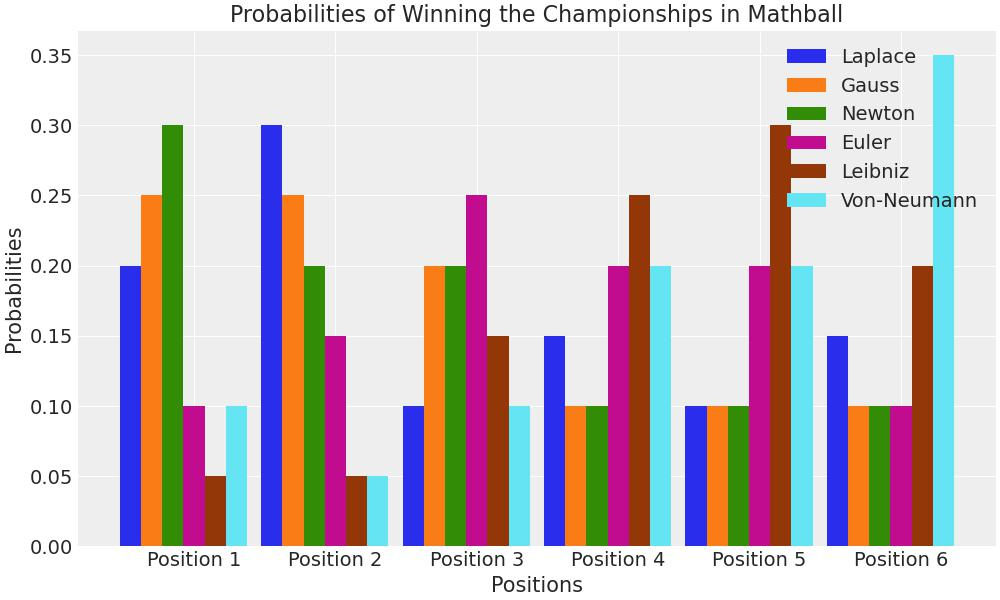

In [41]:
from IPython.display import Image, display
image_path = 'img_bar_chat.jpg'
display(Image(filename=image_path))

## Your code and answers here

### 1. Plot the attack and defence strenght HDI for each team and compare them. Which player has the best offence and which has the best defence? who has the worst offence and defence? Does these results is aligned with part 1 analysis?

Laplace emerges as the player with the best offense, showcasing the highest attack strength among all mathematicians. This finding aligns well with the Part 1 analysis, where Laplace was identified as the top performer based on overall goal difference. On the defensive side, somewhat surprisingly, Leibniz demonstrates the strongest defense despite being previously identified as the worst overall performer. This revelation suggests that Leibniz's poor overall performance is primarily due to a weak offense rather than poor defensive capabilities, at the same time, Leibniz exhibits the worst offense, which is consistent with the earlier analysis identifying him as the poorest overall performer. Euler, on the other hand, appears to have the weakest defense among all mathematicians, an insight that wasn't apparent from the earlier goal difference analysis.

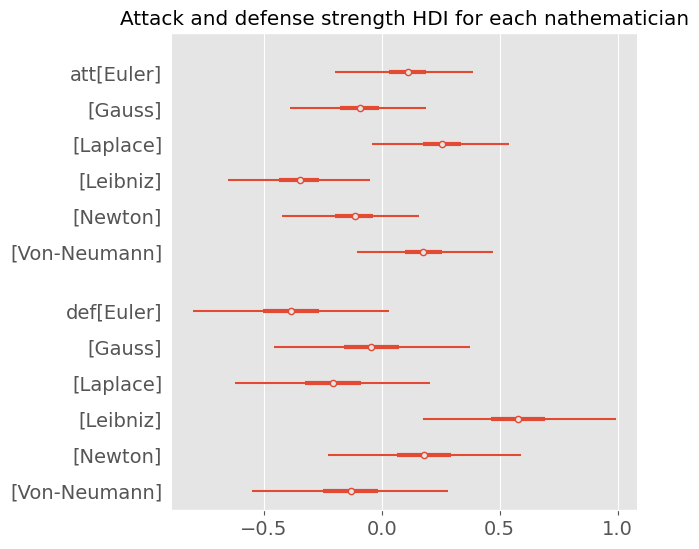

In [42]:
# Plotting the attack and defense strength HDI
az.plot_forest(trace, var_names=["att", "def"], combined=True, hdi_prob=0.95)

plt.title("Attack and defense strength HDI for each nathematician")
plt.show()

In [43]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


### 2. What is the probability that Euler has a better defence than Gauss? 

In [44]:
# Extracting samples from the trace
att_samples = trace.posterior["att"] # Attack samples
def_samples = trace.posterior["def"] # Defence samples

# Indices for Euler and Gauss in home contests
euler_idx = 0
gauss_idx = 1

# Calculate the probability
prob_euler_better_def = (def_samples[:, euler_idx] > def_samples[:, gauss_idx]).mean() # Calculating this probability as the mean of the samples where Euler has a better defence than Gauss
print(f"Probability that Euler has a better defence than Gauss: {prob_euler_better_def:.2f}")

Probability that Euler has a better defence than Gauss: 0.83


### 3. Suppose Leibniz is hosting Newton for a game. What is the probability that Leibniz will score more than 20? what is the probability that Newton will score less than 20?

In [45]:
# Indices for Leibniz and Newton in home contests
leibniz_idx = 3
newton_idx = 4

# Simulating scoring for Leibniz and Newton

# Calculating Leibniz's home scoring rate using an exponential model
# This includes the intercept, home advantage, Leibniz's attack strength, and Newton's defense strength
leibniz_home_rate = np.exp(trace.posterior["intercept"] + trace.posterior["home"] + att_samples[:, leibniz_idx] - def_samples[:, newton_idx])

# Calculating Newton's away scoring rate
# This includes the intercept, Newton's attack strength, and Leibniz's defense strength
newton_away_rate = np.exp(trace.posterior["intercept"] + att_samples[:, newton_idx] - def_samples[:, leibniz_idx])

# Probability calculations
prob_leibniz_more_20 = (leibniz_home_rate > 20).mean()
prob_newton_less_20 = (newton_away_rate < 20).mean()

print(f"Probability that Leibniz will score more than 20: {prob_leibniz_more_20:.2f}")
print(f"Probability that Newton will score less than 20: {prob_newton_less_20:.2f}")

Probability that Leibniz will score more than 20: 0.54
Probability that Newton will score less than 20: 0.42


### 4. Simulate who wins over a total of 4000 simulations, one per sample in the posterior. Hint: use the sample_posterior_predictive function.
### The resulting simulation should give you the score per each game for all possible combinations for 4 seasons. For each sample out of the 4000 we can measure who will be ranked 1st, 2nd, etc. The ranking is done as follows: 
### If a player wins he gets 3 points, draw a single point and lost 0 points. Sum up the points and you will get a full ranking. If we aggregate the results, we can the probability for each player for each position. 

### You are required to draw a bar chart that indicates the probability of all possible ranks for each team.

Sampling: [y1_likelihood, y2_likelihood]


Output()

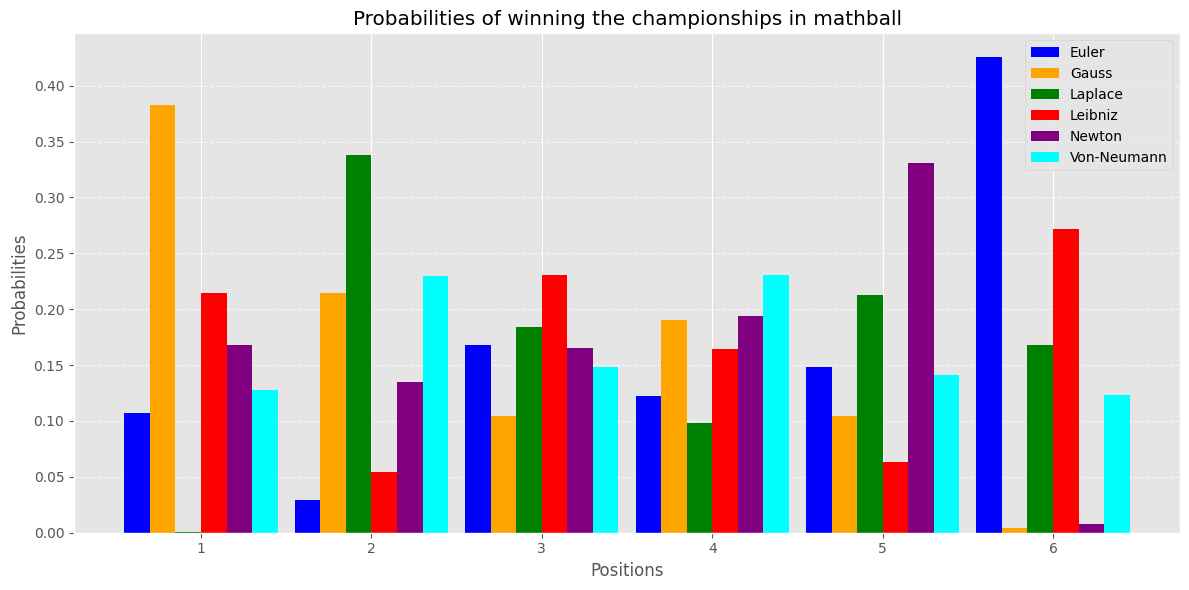

In [46]:
from pymc import sample_posterior_predictive

# Beginnig the simulation within the context of the Bayesian model
with mathball:
    # Generating posterior predictive samples for the likelihoods of outcomes 'y1_likelihood' and 'y2_likelihood'
    ppc = sample_posterior_predictive(trace, var_names=["y1_likelihood", "y2_likelihood"])

# Eesults matrix for the 4000 simulations
n_teams = len(teams)
results = np.zeros((4000, n_teams, n_teams), dtype=int)

# Iteratingeach pair of teams to simulate the match outcomes
for i in range(n_teams):
    for j in range(n_teams):
        if i != j:
            # Extracting the simulated scores for the home and away teams from the posterior predictive samples
            home_goals = ppc.posterior_predictive["y1_likelihood"][:, :, home_idx][0, :, i]
            away_goals = ppc.posterior_predictive["y2_likelihood"][:, :, away_idx][0, :, j]

            # Comparing the scores for each of the 4000 simulations to determine the match outcome
            # This will be based on the requirements of the task
            for k in range(4000):
                if home_goals[k] > away_goals[k]:
                    results[k, i, j] = 3  # Home team wins and receives 3 points
                elif home_goals[k] == away_goals[k]:
                    results[k, i, j] = 1  # The match is a draw; both teams receive 1 point
                else:
                    results[k, i, j] = 0  # Home team loses and receives 0 points

# Sum of the points and ranks for each team
points = results.sum(axis=2)
ranks = points.argsort(axis=1).argsort(axis=1) + 1

# Calculating the probability of each team finishing in each rank position
rank_probs = np.zeros((n_teams, n_teams))
for i in range(n_teams):
    for j in range(n_teams):
        rank_probs[i, j] = (ranks[:, i] == j+1).mean() # Probability matrix

# Number of teams and the positions for the x-axis of the bar chart
n_teams = len(teams)
positions = range(1, n_teams + 1)

plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan']

# Probability bars for each team
bar_width = 0.15
for i, team in enumerate(teams):
    offset = (i - (n_teams - 1) / 2) * bar_width
    plt.bar([p + offset for p in positions], rank_probs[i], 
            width=bar_width, label=team, color=colors[i % len(colors)])

plt.xlabel('Positions')
plt.ylabel('Probabilities')
plt.title('Probabilities of winning the championships in mathball')
plt.xticks(positions)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()